In [1]:
import torch
import os
from pathlib import Path
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from einops import rearrange, repeat
import numpy as np
import MinkowskiEngine as ME
import pickle

DATASET = os.getenv("DATASET")
imagenet_dir = Path(DATASET) / "imagenet" / "ilsvrc2012"
# model = torch.hub.load("facebookresearch/dino:main", "dino_vits16")
torch.no_grad()


In [2]:
with open("output/var/var.p", "rb") as f:
    vars = pickle.load(f)
vars.pop("try_vot_no_shed")


(array([0.00111072, 0.00150287, 0.01454714]),
 array([0.01397969, 0.11907528, 0.28288186]),
 array([ 0, 20, 40]))

In [3]:
variants = {
    "train_no_shed": "vit_small",
    # "train_no_shed_rand_1": "vit_small",
    # "train_no_shed_small_lr": "vit_small",
    # "try_same_patch": "vit_small",
    # "try_vot_no_shed": "vot",
    # "try_vot_no_fp16": "vot",
    # "try_vot_updated_no_shed": "vot",
    # "train_no_shed_no_drop": "vit_small",
    # "train_no_small_crop": "vit_small",
    # "try_vot_no_small_crop": "vot",
    "try_vot_re": "vot",
    "try_vot_re_copy_weights": "vot",
    "try_dino_re": "vit_small",
    "try_vot_replace_patch_embed": "vot_replace_patch_emb",
    "hybrid_dino_patch_emb": "hybrid",
    "hybrid_dino_cls_emb": "hybrid",
    "hybrid_dino_cls_emb_vot_patch_id": "hybrid",
    "hybrid_vot": "hybrid",
    "hybrid_dino_pos_emb": "hybrid",
    "train_subset": "vit_small",
    "try_vot_no_shed": "vot",
}
epochs = np.array([0, 20, 40, 60, 80, 100, 200, 400, 600, 800, 1000, 1180])


In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.CenterCrop(224),
        # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)
dataset = ImageFolder(imagenet_dir / "train", transform)
image = transforms.functional.rotate(dataset[18200][0], 0)
input_image = image.unsqueeze(0)
sinput = ME.to_sparse(input_image)


In [5]:
import vision_transformer as vits
import utils
from vision_transformer import DINOHead
from main_dino import DINOLoss
import os
import yaml
from vot.models.factory import (
    create_model,
    create_optimizer,
    dino_load_checkpoint,
    dino_save_checkpoint,
)
from experiment.hybrid import Hybrid


def get_var_along_training(variant, arch):
    def get_var_from_file(load_file):
        if arch == "vot":
            with open(
                "/home/hli/dl_ws/voxel-transformer/configs/2d_dino.yaml", "r"
            ) as file:
                config = yaml.load(file, Loader=yaml.FullLoader)
            model = create_model(config["model"]).to("cpu").backbone
        elif arch == "vot_replace_patch_emb":
            with open(
                "/home/hli/dl_ws/voxel-transformer/configs/2d_dino.yaml", "r"
            ) as file:
                config = yaml.load(file, Loader=yaml.FullLoader)
            model = create_model(config["model"]).to("cpu").backbone
            emb = vits.__dict__["vit_small"](patch_size=16).patch_embed
            model.patch_embedding = emb
        elif arch == "hybrid":
            model = Hybrid()
        else:
            model = vits.__dict__["vit_small"](patch_size=16)
        utils.load_pretrained_weights(
            model,
            load_file,
            "teacher",
            "vit_small",
            16,
        )
        if arch == "vot":
            patch_emb, hidden_states, sparse_patch_emb = model(sinput, debug=True)
            original_patch_emb = hidden_states[0]
        elif arch == "vot_replace_patch_emb":
            patch_emb, hidden_states, sparse_patch_emb = model(input_image, debug=True)
            original_patch_emb = hidden_states[0]
        else:
            patch_emb, original_patch_emb, pos_emb, hidden_states = model(
                input_image, debug=True
            )
        return (
            patch_emb[0].var(dim=0).mean().item(),
            original_patch_emb[0].var(dim=0).mean().item(),
        )

    vepoch = []
    res = []
    patch_var = []
    for i, epoch in enumerate(epochs):
        load_file = f"/mnt/raid/hli/models/dino/{variant}/checkpoint{epoch:04d}.pth"
        if not os.path.exists(load_file):
            break
        output_var, patch_emb_var = get_var_from_file(load_file)
        res.append(output_var)
        patch_var.append(patch_emb_var)
        vepoch.append(epoch)

    load_file = f"/mnt/raid/hli/models/dino/{variant}/checkpoint.pth"
    output_var, patch_emb_var = get_var_from_file(load_file)
    res.append(output_var)
    patch_var.append(patch_emb_var)
    checkpoint = torch.load(load_file, map_location="cpu")
    vepoch.append(checkpoint["epoch"])
    return np.array(res), np.array(patch_var), np.array(vepoch)


In [6]:
for variant, arch in variants.items():
    if not variant in vars:

        vars[variant] = get_var_along_training(variant, arch)


Take key teacher in provided checkpoint dict
Pretrained weights found at /mnt/raid/hli/models/dino/try_vot_no_shed/checkpoint0000.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Take key teacher in provided checkpoint dict
Pretrained weights found at /mnt/raid/hli/models/dino/try_vot_no_shed/checkpoint0020.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Take key teacher in provided checkpoint dict
Pretrained weights found at /mnt/raid/hli/models/dino/try_vot_no_shed/checkpoint0040.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'hea

In [7]:
with open("output/var/var.p", "wb") as handle:
    pickle.dump(vars, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [8]:
selection = ["train_no_shed", "train_subset", "try_vot_no_shed", "hybrid_vot"]


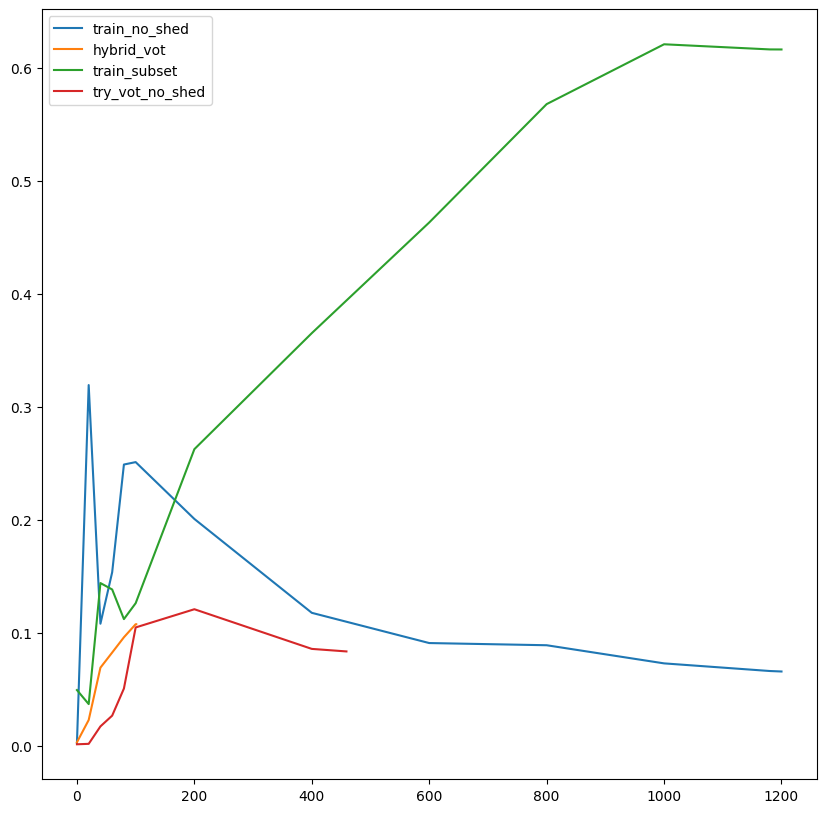

In [9]:
fig, ax = plt.subplots(figsize=[10, 10])
for key, value in vars.items():
    if not key in selection:
        continue
    ax.plot(value[2], value[0], label=key)
ax.legend()
# ax.set_xlim([0, 50])
# ax.set_ylim([0, 0.5])


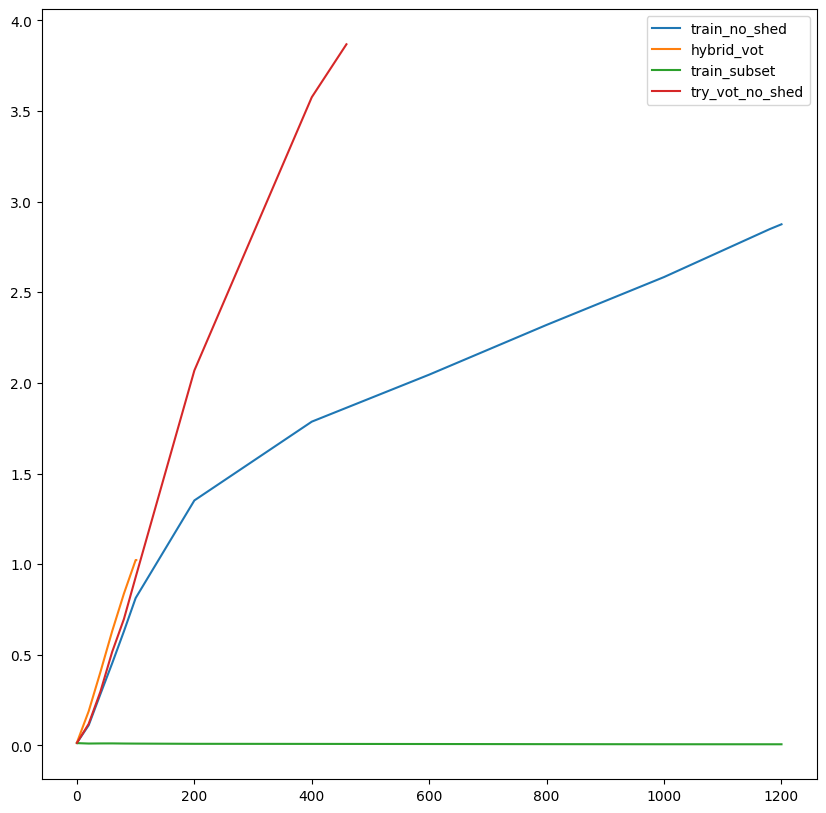

In [10]:
fig, ax = plt.subplots(figsize=[10, 10])
for key, value in vars.items():
    if not key in selection:
        continue
    ax.plot(value[2], value[1], label=key)
ax.legend()
